In [31]:
import kagglehub
import os
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [ ]:
# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [01:02<00:00, 11.4MB/s] 

Extracting files...


Path to dataset files: /home/ao627515/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [10]:
!cp -r ~/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images ./datasets

In [6]:
def create_dataset(dossier_source, dossier_dest, test_size=0.2, val_size=0.1):
    """
    Crée un dataset structuré en train / val / test à partir d'un dossier source.

    Args:
        dossier_source (str): chemin vers le dossier contenant les sous-dossiers par classe
        dossier_dest (str): chemin vers le dossier de destination
        test_size (float): proportion d'images pour le test
        val_size (float): proportion d'images pour la validation (sur le train)

    Returns:
        dict: dictionnaire contenant les chemins et statistiques
    """
    # Création des dossiers principaux train, val et test
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(dossier_dest, split), exist_ok=True)

    # Liste des classes (sous-dossiers)
    classes = [
        d
        for d in os.listdir(dossier_source)
        if os.path.isdir(os.path.join(dossier_source, d))
    ]

    stats = {"total": 0, "train": 0, "val": 0, "test": 0, "classes": {}, "paths": {}}

    for classe in classes:
        print(f"Traitement de la classe: {classe}")

        chemin_classe = os.path.join(dossier_source, classe)
        images = [
            f
            for f in os.listdir(chemin_classe)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        # Split train+val et test
        train_val_imgs, test_imgs = train_test_split(
            images, test_size=test_size, random_state=42
        )
        # Split train et val
        train_imgs, val_imgs = train_test_split(
            train_val_imgs, test_size=val_size, random_state=42
        )

        # Création des sous-dossiers pour chaque split
        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(dossier_dest, split, classe), exist_ok=True)

        # Copie des images
        for img in train_imgs:
            shutil.copy2(
                os.path.join(chemin_classe, img),
                os.path.join(dossier_dest, "train", classe, img),
            )
        for img in val_imgs:
            shutil.copy2(
                os.path.join(chemin_classe, img),
                os.path.join(dossier_dest, "val", classe, img),
            )
        for img in test_imgs:
            shutil.copy2(
                os.path.join(chemin_classe, img),
                os.path.join(dossier_dest, "test", classe, img),
            )

        # Mise à jour des stats
        stats["total"] += len(images)
        stats["train"] += len(train_imgs)
        stats["val"] += len(val_imgs)
        stats["test"] += len(test_imgs)
        stats["classes"][classe] = {
            "total": len(images),
            "train": len(train_imgs),
            "val": len(val_imgs),
            "test": len(test_imgs),
        }

        print(
            f"  Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}"
        )

    # Ajout des chemins vers chaque split
    stats["paths"] = {
        "train": os.path.join(dossier_dest, "train"),
        "val": os.path.join(dossier_dest, "val"),
        "test": os.path.join(dossier_dest, "test"),
    }

    # Affichage des stats finales
    print(f"\n{'='*50}")
    print("STATISTIQUES DU DATASET")
    print(f"{'='*50}")
    print(f"Images totales: {stats['total']}")
    print(f"Train: {stats['train']} ({stats['train']/stats['total']*100:.1f}%)")
    print(f"Val: {stats['val']} ({stats['val']/stats['total']*100:.1f}%)")
    print(f"Test: {stats['test']} ({stats['test']/stats['total']*100:.1f}%)")
    print(f"\nDétail par classe:")
    for classe, data in stats["classes"].items():
        print(
            f"  {classe}: {data['total']} (train: {data['train']}, val: {data['val']}, test: {data['test']})"
        )
    print(f"{'='*50}\n")

    return stats

In [26]:
dataset_paths = create_dataset("./datasets/cell_images", "./datasets/malaria_dataset", test_size=0.2, val_size=0.1)

train_dataset = dataset_paths["paths"]["train"]
val_dataset = dataset_paths["paths"]["val"]
test_dataset = dataset_paths["paths"]["test"]
print(train_dataset)
print(val_dataset)
print(test_dataset)

Traitement de la classe: Parasitized
  Train: 9920, Val: 1103, Test: 2756
Traitement de la classe: Uninfected
  Train: 9920, Val: 1103, Test: 2756

STATISTIQUES DU DATASET
Images totales: 27558
Train: 19840 (72.0%)
Val: 2206 (8.0%)
Test: 5512 (20.0%)

Détail par classe:
  Parasitized: 13779 (train: 9920, val: 1103, test: 2756)
  Uninfected: 13779 (train: 9920, val: 1103, test: 2756)

./datasets/malaria_dataset/train
./datasets/malaria_dataset/val
./datasets/malaria_dataset/test


In [13]:
def classify_cell_image_imagenet(image_path):
    """
    Teste DenseNet121 pré-entraîné sur ImageNet pour une image de cellule sanguine.
    Pas de fine-tuning, juste pour observer les prédictions brutes.

    Args:
        image_path (str): chemin vers l'image à classifier

    Returns:
        dict: top 5 prédictions ImageNet avec labels et probabilités
    """
    # Charger DenseNet121 pré-entraîné ImageNet
    model = models.densenet121(pretrained=True)
    model.eval()

    # Prétraitement standard ImageNet
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Charger l'image
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0)  # ajouter batch dimension

    # Prédiction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]

    # Charger les labels ImageNet
    import json, urllib.request

    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    with urllib.request.urlopen(url) as f:
        labels = json.load(f)

    # Top 5 prédictions
    top_idx = np.argsort(probs)[::-1][:5]
    top_labels = [labels[i] for i in top_idx]
    top_probs = probs[top_idx]

    # Affichage
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img)
    axes[0].set_title("Image de la cellule")
    axes[0].axis("off")

    axes[1].barh(top_labels, top_probs * 100, color="skyblue")
    axes[1].set_xlabel("Confiance (%)")
    axes[1].set_title("Top 5 prédictions ImageNet")
    axes[1].invert_yaxis()
    for i, (label, score) in enumerate(zip(top_labels, top_probs * 100)):
        axes[1].text(score + 1, i, f"{score:.1f}%", va="center")

    plt.tight_layout()
    plt.show()

    # Affichage console
    print("\n=== Top 5 prédictions ===")
    for i, (label, score) in enumerate(zip(top_labels, top_probs), 1):
        print(f"{i}. {label}: {score*100:.2f}%")

    return {label: float(score) for label, score in zip(top_labels, top_probs)}

/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/ao627515/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:01<00:00, 26.3MB/s]


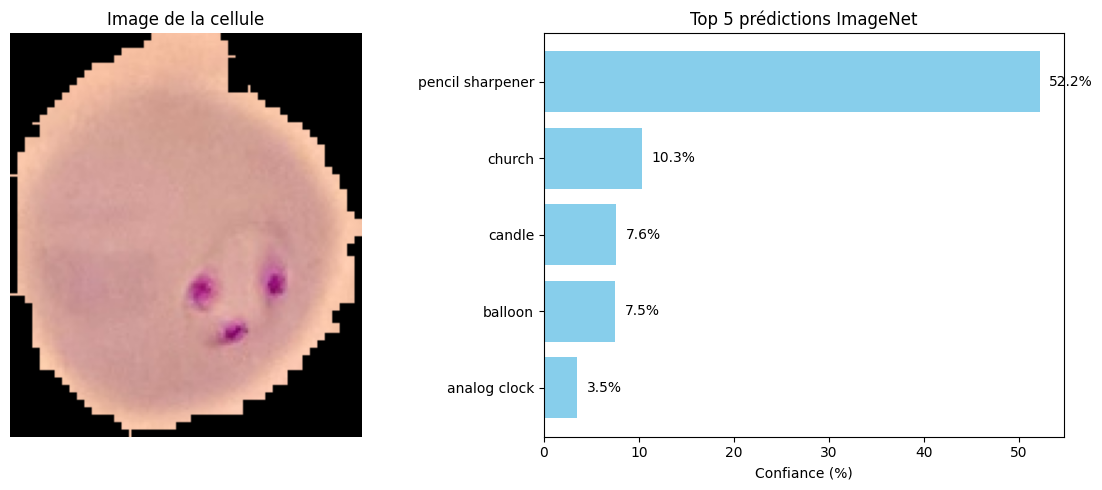


=== Top 5 prédictions ===
1. pencil sharpener: 52.19%
2. church: 10.30%
3. candle: 7.63%
4. balloon: 7.55%
5. analog clock: 3.52%


{'pencil sharpener': 0.5219147205352783,
 'church': 0.10304304957389832,
 'candle': 0.07626739144325256,
 'balloon': 0.07545299828052521,
 'analog clock': 0.03524068370461464}

In [22]:
classify_cell_image_imagenet("./datasets/malaria_dataset/test/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png")

In [ ]:
def create_densenet121_model(num_classes, img_size=224):
    """
    Crée un modèle de classification d'images avec DenseNet121 et transfer learning.

    Args:
        num_classes (int): nombre de classes à prédire
        img_size (int): taille des images d'entrée (img_size x img_size)

    Returns:
        keras.Model: modèle prêt à être compilé et entraîné
    """

    # Base DenseNet121 pré-entraînée sur ImageNet
    base_model = DenseNet121(
        input_shape=(img_size, img_size, 3),
        include_top=False,  # Supprime la couche de sortie originale
        weights="imagenet",  # Utilise les poids pré-entraînés sur ImageNet
    )

    # Geler les couches de base pour ne pas les entraîner au début
    base_model.trainable = False

    # Ajouter des couches personnalisées pour notre tâche
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Réduit chaque feature map à une moyenne
    x = Dense(128, activation="relu")(x)  # Couche fully connected
    x = Dropout(0.5)(x)  # Régularisation pour éviter l'overfitting
    predictions = Dense(num_classes, activation="softmax")(x)  # Couche de sortie

    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
# model = create_densenet121_model(num_classes=2)

In [ ]:
def train_densenet121_model(
    train_dataset,
    val_dataset,
    test_dataset,
    num_classes,
    epochs=10,
    learning_rate=0.0001,
    img_size=224,
    batch_size=32,
):
    """
    Entraîne un modèle DenseNet121 pour détecter les cellules infectées par le paludisme.
    Les datasets sont des chemins vers des dossiers contenant les sous-dossiers des classes.

    Args:
        train_dataset (str): chemin vers le dossier train
        val_dataset (str): chemin vers le dossier validation
        test_dataset (str): chemin vers le dossier test
        num_classes (int): nombre de classes (ex: 2 pour infected/uninfected)
        epochs (int): nombre d’époques d’entraînement
        learning_rate (float): taux d’apprentissage
        img_size (int): taille des images (img_size x img_size)
        batch_size (int): taille des batches

    Returns:
        model: modèle entraîné
        history: historique de l’entraînement
    """

    # --- 1. Générateurs d'images ---
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode="nearest",
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_gen = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    val_gen = val_test_datagen.flow_from_directory(
        val_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    test_gen = val_test_datagen.flow_from_directory(
        test_dataset,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    # --- 2. Créer le modèle DenseNet121 ---
    model = create_densenet121_model(num_classes=num_classes, img_size=img_size)

    # --- 3. Compiler le modèle ---
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # --- 4. Callbacks ---
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        ),
        ModelCheckpoint(
            "exports/models/best_densenet121_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1,
        ),
    ]

    # --- 5. Entraînement ---
    print("\n🚀 Début de l'entraînement sur DenseNet121...\n")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # --- 6. Évaluation sur le test set ---
    print("\n🔍 Évaluation sur le jeu de test :")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"✅ Précision sur le test set : {test_acc*100:.2f}%")

    # --- 7. Sauvegarde du modèle final ---
    model.save("exports/models/densenet121_malaria_classifier.keras")
    print("\n💾 Modèle final sauvegardé : densenet121_malaria_classifier.keras")

    # --- 8. Visualisation de l'entraînement ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(history.history["accuracy"], label="Entraînement")
    axes[0].plot(history.history["val_accuracy"], label="Validation")
    axes[0].set_title("Évolution de la précision")
    axes[0].set_xlabel("Époque")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(history.history["loss"], label="Entraînement")
    axes[1].plot(history.history["val_loss"], label="Validation")
    axes[1].set_title("Évolution de la perte")
    axes[1].set_xlabel("Époque")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, history, train_gen.class_indices

Found 19840 images belonging to 2 classes.
Found 2206 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.

🚀 Début de l'entraînement sur DenseNet121...



/home/ao627515/Formations/odc/computer_vision_exam/.venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7051 - loss: 0.6085
Epoch 1: val_accuracy improved from None to 0.89755, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1377s 2s/step - accuracy: 0.7976 - loss: 0.4468 - val_accuracy: 0.8976 - val_loss: 0.2829
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8794 - loss: 0.3039
Epoch 2: val_accuracy improved from 0.89755 to 0.91070, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1469s 2s/step - accuracy: 0.8828 - loss: 0.2992 - val_accuracy: 0.9107 - val_loss: 0.2424
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8962 - loss: 0.2660
Epoch 3: val_accuracy improved from 0.91070 to 0.91251, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1693s 3s/step - accuracy: 0.8951 - loss: 0.2727 - val_accuracy: 0.9125 - val_loss: 0.2280
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9043 - loss: 0.2601
Epoch 4: val_accuracy improved from 0.91251 to 0.91750, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1686s 3s/step - accuracy: 0.9043 - loss: 0.2588 - val_accuracy: 0.9175 - val_loss: 0.2125
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9035 - loss: 0.2619
Epoch 5: val_accuracy did not improve from 0.91750
620/620 ━━━━━━━━━━━━━━━━━━━━ 1439s 2s/step - accuracy: 0.9056 - loss: 0.2545 - val_accuracy: 0.9175 - val_loss: 0.2149
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9115 - loss: 0.2433
Epoch 6: val_accuracy improved from 0.91750 to 0.91840, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1418s 2s/step - accuracy: 0.9116 - loss: 0.2418 - val_accuracy: 0.9184 - val_loss: 0.2105
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9123 - loss: 0.2371
Epoch 7: val_accuracy improved from 0.91840 to 0.92702, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1656s 3s/step - accuracy: 0.9140 - loss: 0.2361 - val_accuracy: 0.9270 - val_loss: 0.2020
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9091 - loss: 0.2430
Epoch 8: val_accuracy did not improve from 0.92702
620/620 ━━━━━━━━━━━━━━━━━━━━ 1511s 2s/step - accuracy: 0.9095 - loss: 0.2409 - val_accuracy: 0.9266 - val_loss: 0.1939
Epoch 9/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9195 - loss: 0.2236
Epoch 9: val_accuracy improved from 0.92702 to 0.93518, saving model to exports/models/best_densenet121_model.h5


620/620 ━━━━━━━━━━━━━━━━━━━━ 1480s 2s/step - accuracy: 0.9163 - loss: 0.2293 - val_accuracy: 0.9352 - val_loss: 0.1828
Epoch 10/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9157 - loss: 0.2289
Epoch 10: val_accuracy did not improve from 0.93518
620/620 ━━━━━━━━━━━━━━━━━━━━ 1509s 2s/step - accuracy: 0.9169 - loss: 0.2261 - val_accuracy: 0.9234 - val_loss: 0.1940

🔍 Évaluation sur le jeu de test :
173/173 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9278 - loss: 0.1911


✅ Précision sur le test set : 92.78%

💾 Modèle final sauvegardé : densenet121_malaria_classifier.h5


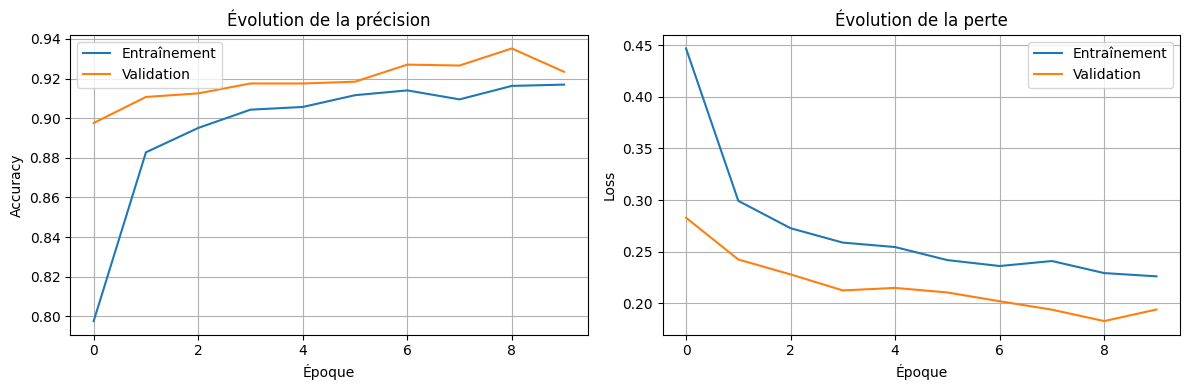

(<Functional name=functional_4, built=True>,
 <keras.src.callbacks.history.History at 0x79a139da0830>)

In [ ]:
model, history, class_indices = train_densenet121_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    num_classes=2,
    epochs=10,
    learning_rate=0.0001,
)

In [32]:
class MalariaCellClassifier:
    """Classificateur de cellules sanguines pour détecter le paludisme"""

    def __init__(self, model_path, class_indices):
        """
        Args:
            model_path (str): chemin vers le modèle entraîné (.h5 ou .keras)
            class_indices (dict): dictionnaire {nom_classe: indice} retourné par ImageDataGenerator
        """
        # Charger le modèle
        self.model = load_model(model_path)

        # Inverser le dictionnaire pour récupérer le nom de la classe à partir de l'indice
        self.classes = {v: k for k, v in class_indices.items()}

    def predict_cell(self, image_path):
        """Prédit la classe d'une cellule sur une image"""
        # Charger l'image et redimensionner à 224x224
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisation

        # Obtenir les probabilités
        predictions = self.model.predict(img_array, verbose=0)
        class_idx = np.argmax(predictions[0])
        confidence = predictions[0][class_idx]
        class_name = self.classes[class_idx]

        return class_name, confidence, predictions[0]

    def predict_and_display(self, image_path):
        """Affiche l'image et les probabilités par classe"""
        class_name, confidence, all_probs = self.predict_cell(image_path)

        # Préparer la figure
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Image originale
        img = image.load_img(image_path)
        axes[0].imshow(img)
        axes[0].set_title(f"Prédiction: {class_name}\nConfiance: {confidence*100:.1f}%")
        axes[0].axis("off")

        # Histogramme des probabilités
        class_names = [self.classes[i] for i in range(len(all_probs))]
        probs = all_probs * 100  # Convertir en %
        colors = [
            "green" if i == np.argmax(all_probs) else "skyblue"
            for i in range(len(probs))
        ]

        axes[1].barh(class_names, probs, color=colors)
        axes[1].set_xlabel("Probabilité (%)")
        axes[1].set_title("Confiance par classe")
        for i, (name, prob) in enumerate(zip(class_names, probs)):
            axes[1].text(prob + 1, i, f"{prob:.1f}%", va="center")

        plt.tight_layout()
        plt.show()

        # Affichage console
        print(f"\n=== RÉSULTAT ===")
        print(f"Classe prédite: {class_name}")
        print(f"Confiance: {confidence*100:.2f}%")

        return class_name, confidence

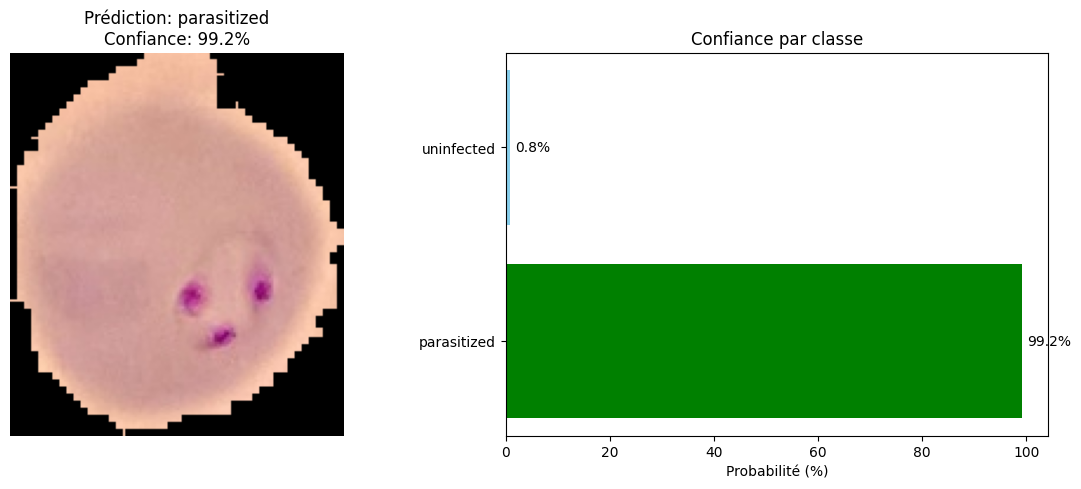


=== RÉSULTAT ===
Classe prédite: parasitized
Confiance: 99.20%


In [33]:
classifier = MalariaCellClassifier(
    model_path="exports/models/densenet121_malaria_classifier.h5",
    class_indices={"parasitized": 0, "uninfected": 1},
)

class_name, confidence = classifier.predict_and_display(
    "./datasets/malaria_dataset/test/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png"
)

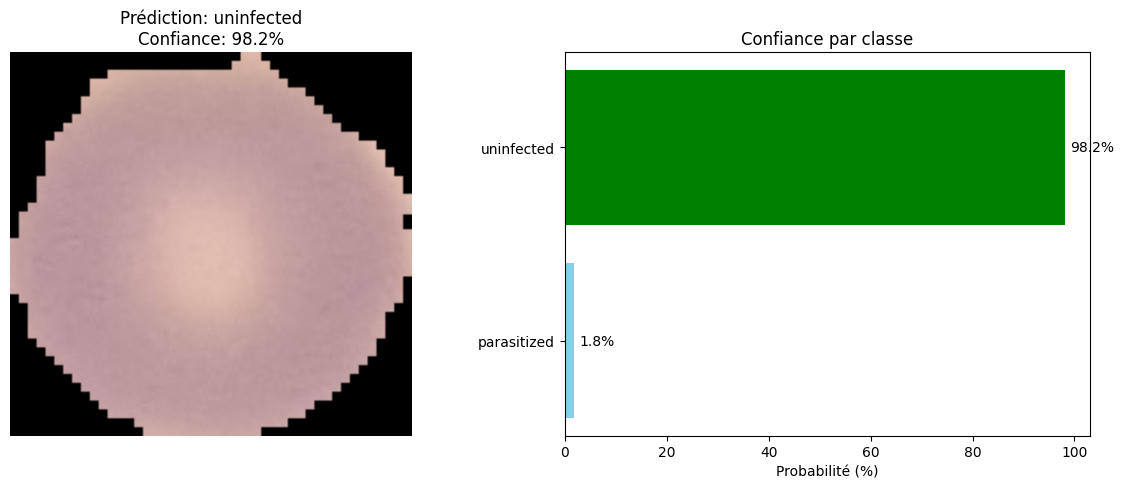


=== RÉSULTAT ===
Classe prédite: uninfected
Confiance: 98.17%


In [35]:
class_name, confidence = classifier.predict_and_display(
    "./datasets/malaria_dataset/test/Uninfected/C1_thinF_IMG_20150604_104722_cell_191.png"
)

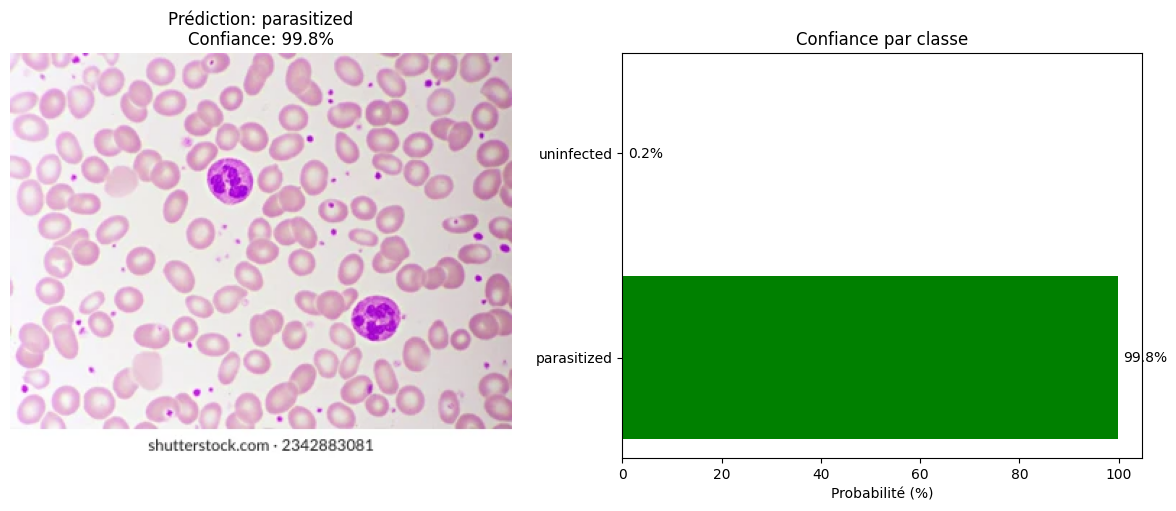


=== RÉSULTAT ===
Classe prédite: parasitized
Confiance: 99.81%


In [36]:
class_name, confidence = classifier.predict_and_display(
    "./assets/imgs/unknown_cells/frotti_1.webp"
)

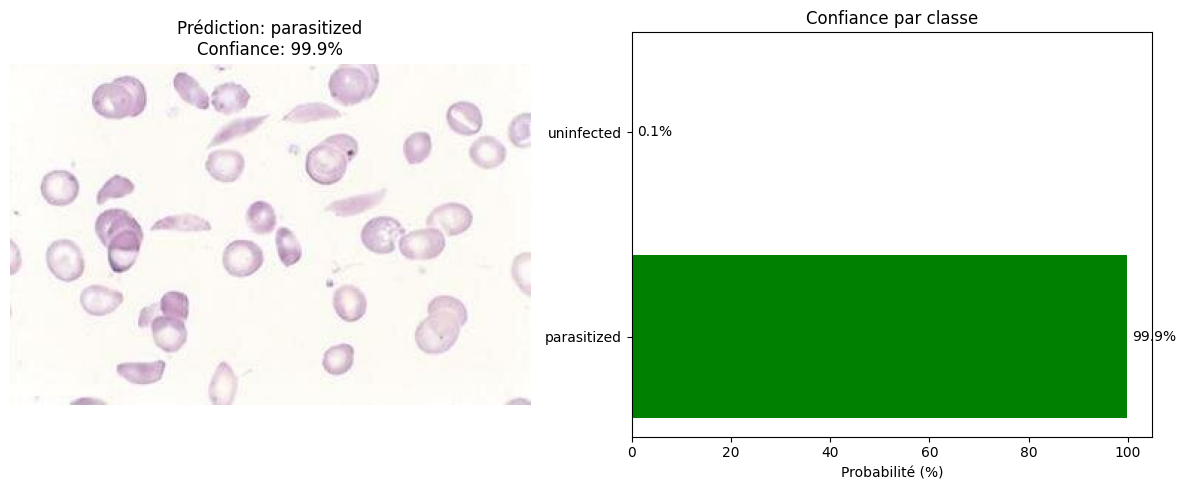


=== RÉSULTAT ===
Classe prédite: parasitized
Confiance: 99.90%


In [37]:
class_name, confidence = classifier.predict_and_display(
    "./assets/imgs/unknown_cells/frotti_2.png"
)